In [1]:
import lmfit
import xarray as xr
import pandas as pd
import numpy as np
import copy

import glob

import xrft
import finufft

from uncertainties import ufloat
from uncertainties import unumpy as unp
from uncertainties import umath

from datetime import datetime

import matplotlib.pyplot as plt

#test
plt.rcParams['font.size'] = 18

from scipy.ndimage import gaussian_filter, rotate
import matplotlib as mpl
from scipy.interpolate import CubicSpline
from scipy.optimize import curve_fit
mpl.rc('xtick', labelsize=8)
mpl.rc('ytick', labelsize=8)

import sys
sys.path.append("C:/Users/Jianshun Gao/VisualCodeProjects/analysescript")
sys.path.append("C:/Users/Jianshun Gao/PycharmProjects/Foglight4/Data")

from DataContainer.ReadData import read_hdf5_file, read_hdf5_global, read_hdf5_run_time, read_csv_file
from Analyser.ImagingAnalyser import ImageAnalyser
from Analyser.FitAnalyser import FitAnalyser
from Analyser.FitAnalyser import ThomasFermi2dModel, DensityProfileBEC2dModel, Polylog22dModel
from Analyser.FFTAnalyser import fft, ifft, fft_nutou
from ToolFunction.ToolFunction import *

import time
import logging as log
import scipy.constants as const

from ToolFunction.HomeMadeXarrayFunction import errorbar, dataarray_plot_errorbar
xr.plot.dataarray_plot.errorbar = errorbar
xr.plot.accessor.DataArrayPlotAccessor.errorbar = dataarray_plot_errorbar

imageAnalyser = ImageAnalyser()


import Analyser.FitAnalyser as dp

In [2]:
path = "C:/Users/Jianshun Gao/PycharmProjects/Foglight4/Data"
file = 'high_cond_1'
file_path = f'{path}/josch/{file}.nc'
print(file_path)
with xr.open_dataarray(file_path) as data_x:
    data_x

data = data_x.to_numpy()

C:/Users/Jianshun Gao/PycharmProjects/Foglight4/Data/josch/high_cond_1.nc


In [3]:
is_debug = True
fitm = DensityProfileBEC2dModel(is_debug=is_debug, atom_n_conv=144/2)

def calc_cen_bulk(thresh):
    """
    returns array in shape of input, containing array with [Y_center,X_center] for each image
    """
    shape = np.shape(thresh)
    cen = np.zeros((shape[0], 2))
    for i in range(0, shape[0]):
        cen[i] = fitm.calc_cen_pix(thresh[i])
    return cen

In [4]:
shape = np.shape(data)
data_rot = np.empty(shape)

for i in range(0,shape[0]):
    data_rot[i] = rotate(data[i], 36, reshape=False)

In [5]:
# cropping
pr_data = data_rot

cut_width_x = 200
cut_width_y = 150
thresh = fitm.calc_thresh(pr_data)

center = calc_cen_bulk(thresh)

print(center)


if len(shape) == 3:
    cropOD = np.zeros((shape[0], cut_width_y, cut_width_x))
    for i in range(0,shape[0]):
        for j in range(0, shape[1]):
            cropOD[i] = pr_data[i, round(center[i,0]-cut_width_y/2):round(center[i,0]+cut_width_y/2), round(center[i,1]-cut_width_x/2):round(center[i,1]+cut_width_x/2)]

shape = np.shape(cropOD)

[[599.42377261 959.62015504]
 [599.46599496 959.50629723]
 [599.47858942 959.49118388]
 [599.47505938 959.41330166]
 [599.68149883 959.26697892]
 [599.4627907  959.58372093]
 [599.46412556 959.46188341]]


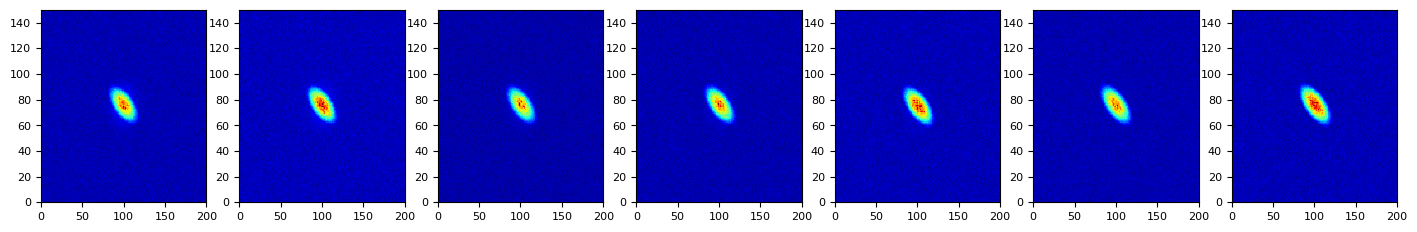

In [6]:
fig, ax = plt.subplots(1, shape[0], figsize=(2.5 *shape[0],2.5))
for i in range(0, shape[0]):
    ax[i].pcolormesh(cropOD[i], cmap='jet')

plt.show()


 
file high_cond_1 
 image: 0
shape: (200, 150)


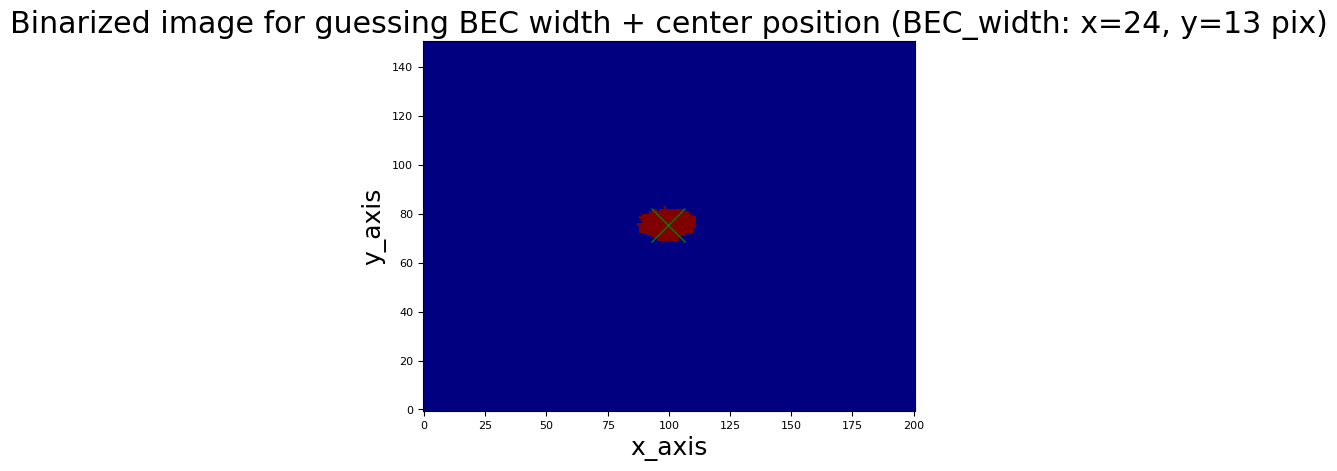

y smaller x, 1d fit along y

1d fit initialization
center = [99.49748744 75.5033557 ]
BEC widths: [24 13]

1d init fit values
Name          Value      Min      Max   Stderr     Vary     Expr Brute_Step
amp_bec       1.805        0    4.694     None     True     None     None
amp_th        1.805        0    4.694     None     True     None     None
deltax           39        0      200     None     True     None     None
sigma_bec     10.66        0       26     None     True     None     None
sigma_th      26.94        0      inf     None    False 0.632*sigma_bec + 0.518*deltax     None
x0_bec         75.5     65.5     85.5     None     True     None     None
x0_th          75.5     65.5     85.5     None     True     None     None
1d fitted values
x0_bec: 75.823, (init = 75.503), bounds = [65.50 : 85.50] 
x0_th: 75.762, (init = 75.503), bounds = [65.50 : 85.50] 
amp_bec: 2.929, (init = 1.805), bounds = [0.00 : 4.69] 
amp_th: 0.722, (init = 1.805), bounds = [0.00 : 4.69] 
sigma_bec: 10

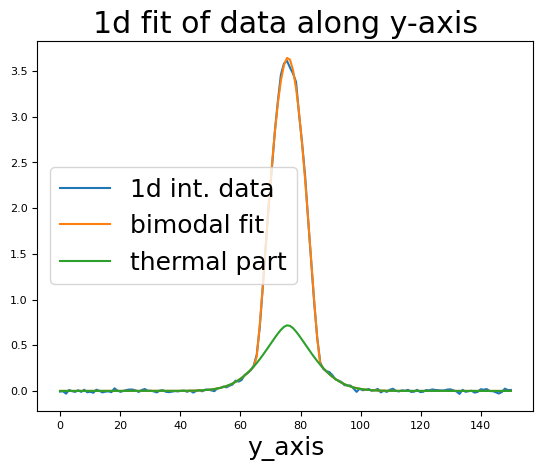


Init Params
Name                    Value      Min      Max   Stderr     Vary     Expr Brute_Step
amp_bec                 3.515        0    6.495     None     True     None     None
amp_th                  0.866        0    6.495     None     True     None     None
atom_number_bec         942.7     -inf      inf     None    False amp_bec / 5 * 2 * 3.14159265359 * sigmax_bec * sigmay_bec     None
atom_number_th          387.7     -inf      inf     None    False amp_th * 2 * 3.14159265359 * 1.20206 / 1.643 * sigma_th * sigma_th     None
condensate_fraction    0.7086     -inf      inf     None    False atom_number_bec / (atom_number_bec + atom_number_th)     None
rot_angle                 -36      -66       -6     None    False     None     None
sigma_th                9.869        0      200     None     True     None     None
sigmax_bec              19.67        0       48     None     True     None     None
sigmay_bec              10.85        0       26     None     True     None    

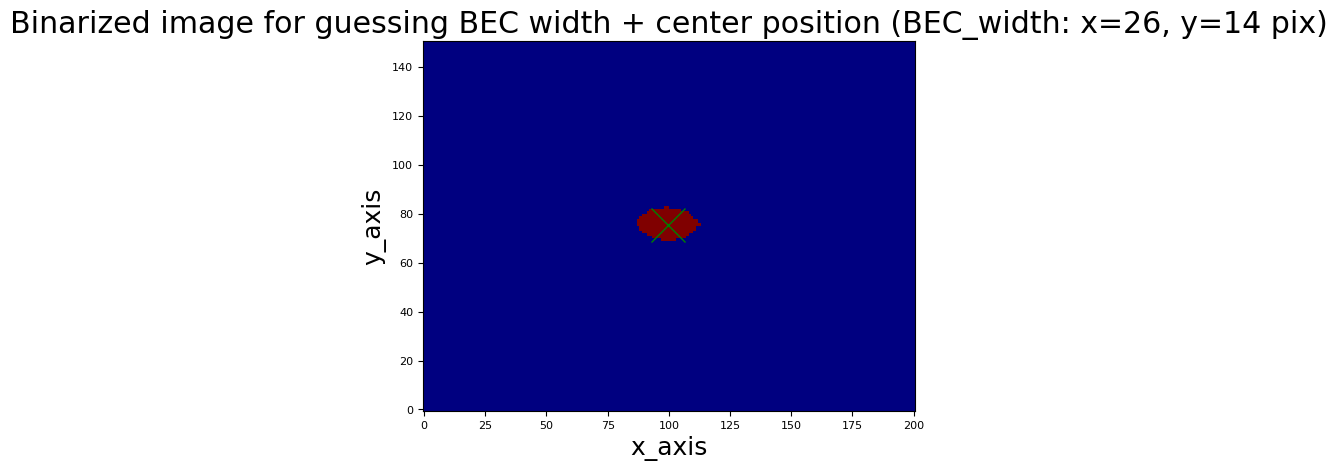

y smaller x, 1d fit along y

1d fit initialization
center = [99.49748744 75.5033557 ]
BEC widths: [26 14]

1d init fit values
Name          Value      Min      Max   Stderr     Vary     Expr Brute_Step
amp_bec       1.733        0    4.505     None     True     None     None
amp_th        1.733        0    4.505     None     True     None     None
deltax           42        0      200     None     True     None     None
sigma_bec     11.48        0       28     None     True     None     None
sigma_th      29.01        0      inf     None    False 0.632*sigma_bec + 0.518*deltax     None
x0_bec         75.5     65.5     85.5     None     True     None     None
x0_th          75.5     65.5     85.5     None     True     None     None
1d fitted values
x0_bec: 75.810, (init = 75.503), bounds = [65.50 : 85.50] 
x0_th: 75.715, (init = 75.503), bounds = [65.50 : 85.50] 
amp_bec: 2.951, (init = 1.733), bounds = [0.00 : 4.51] 
amp_th: 0.574, (init = 1.733), bounds = [0.00 : 4.51] 
sigma_bec: 11

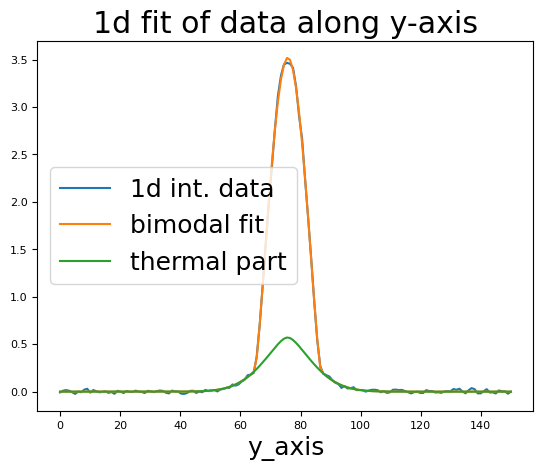


Init Params
Name                    Value      Min      Max   Stderr     Vary     Expr Brute_Step
amp_bec                 3.554        0    6.284     None     True     None     None
amp_th                 0.6913        0    6.284     None     True     None     None
atom_number_bec          1051     -inf      inf     None    False amp_bec / 5 * 2 * 3.14159265359 * sigmax_bec * sigmay_bec     None
atom_number_th          300.6     -inf      inf     None    False amp_th * 2 * 3.14159265359 * 1.20206 / 1.643 * sigma_th * sigma_th     None
condensate_fraction    0.7776     -inf      inf     None    False atom_number_bec / (atom_number_bec + atom_number_th)     None
rot_angle                 -36      -66       -6     None    False     None     None
sigma_th                9.725        0      200     None     True     None     None
sigmax_bec              21.31        0       52     None     True     None     None
sigmay_bec              11.04        0       28     None     True     None    

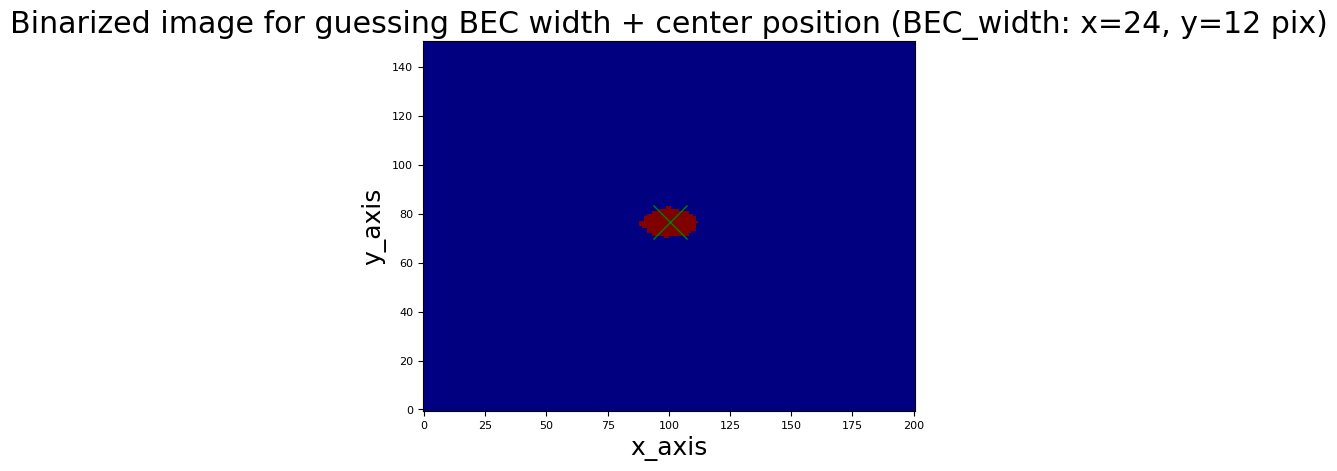

y smaller x, 1d fit along y

1d fit initialization
center = [100.50251256  76.51006711]
BEC widths: [24 12]

1d init fit values
Name          Value      Min      Max   Stderr     Vary     Expr Brute_Step
amp_bec       1.886        0    4.903     None     True     None     None
amp_th        1.886        0    4.903     None     True     None     None
deltax           36        0      200     None     True     None     None
sigma_bec     9.836        0       24     None     True     None     None
sigma_th      24.86        0      inf     None    False 0.632*sigma_bec + 0.518*deltax     None
x0_bec        76.51    66.51    86.51     None     True     None     None
x0_th         76.51    66.51    86.51     None     True     None     None
1d fitted values
x0_bec: 76.429, (init = 76.510), bounds = [66.51 : 86.51] 
x0_th: 76.225, (init = 76.510), bounds = [66.51 : 86.51] 
amp_bec: 3.016, (init = 1.886), bounds = [0.00 : 4.90] 
amp_th: 0.716, (init = 1.886), bounds = [0.00 : 4.90] 
sigma_bec: 

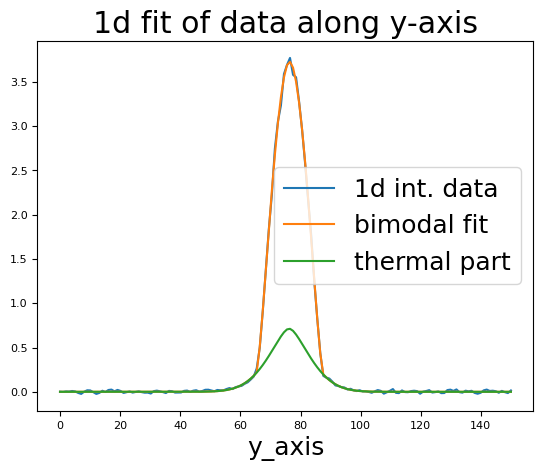


Init Params
Name                    Value      Min      Max   Stderr     Vary     Expr Brute_Step
amp_bec                 3.665        0    7.277     None     True     None     None
amp_th                 0.8706        0    7.277     None     True     None     None
atom_number_bec          1006     -inf      inf     None    False amp_bec / 5 * 2 * 3.14159265359 * sigmax_bec * sigmay_bec     None
atom_number_th          281.5     -inf      inf     None    False amp_th * 2 * 3.14159265359 * 1.20206 / 1.643 * sigma_th * sigma_th     None
condensate_fraction    0.7813     -inf      inf     None    False atom_number_bec / (atom_number_bec + atom_number_th)     None
rot_angle                 -36      -66       -6     None    False     None     None
sigma_th                8.387        0      200     None     True     None     None
sigmax_bec              19.67        0       48     None     True     None     None
sigmay_bec               11.1        0       24     None     True     None    

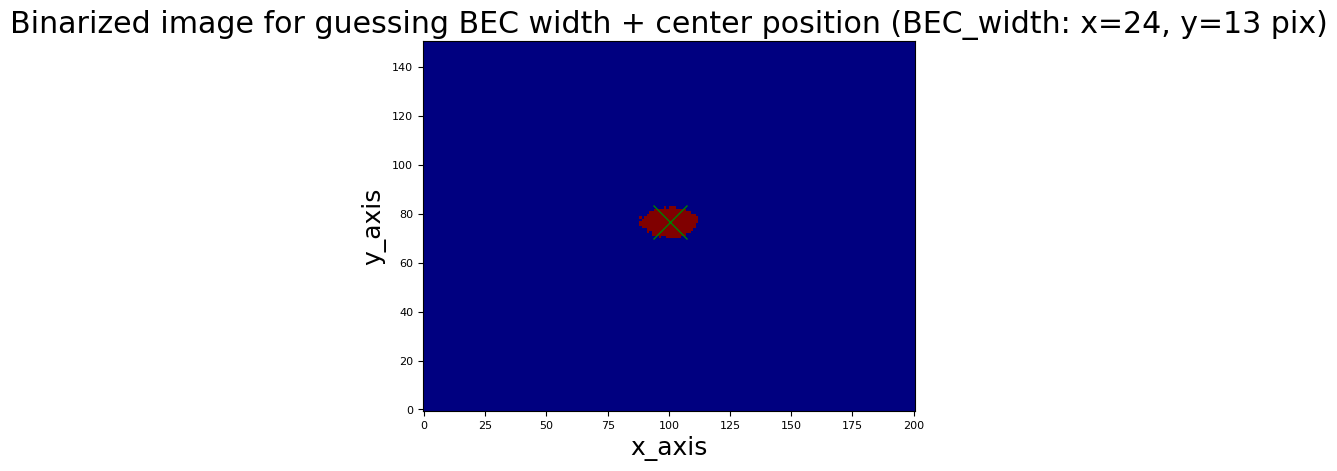

y smaller x, 1d fit along y

1d fit initialization
center = [100.50251256  76.51006711]
BEC widths: [24 13]

1d init fit values
Name          Value      Min      Max   Stderr     Vary     Expr Brute_Step
amp_bec       1.868        0    4.856     None     True     None     None
amp_th        1.868        0    4.856     None     True     None     None
deltax           39        0      200     None     True     None     None
sigma_bec     10.66        0       26     None     True     None     None
sigma_th      26.94        0      inf     None    False 0.632*sigma_bec + 0.518*deltax     None
x0_bec        76.51    66.51    86.51     None     True     None     None
x0_th         76.51    66.51    86.51     None     True     None     None
1d fitted values
x0_bec: 76.418, (init = 76.510), bounds = [66.51 : 86.51] 
x0_th: 76.448, (init = 76.510), bounds = [66.51 : 86.51] 
amp_bec: 3.137, (init = 1.868), bounds = [0.00 : 4.86] 
amp_th: 0.548, (init = 1.868), bounds = [0.00 : 4.86] 
sigma_bec: 

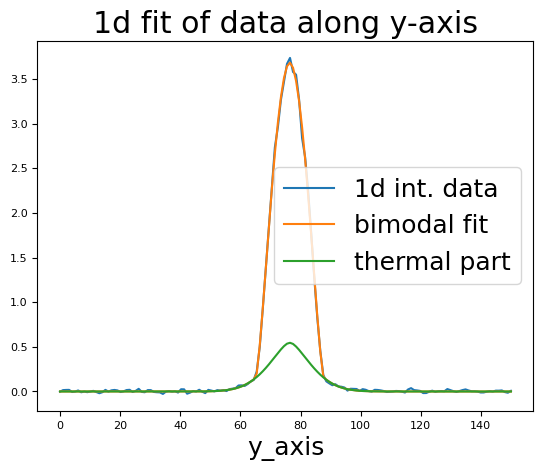


Init Params
Name                    Value      Min      Max   Stderr     Vary     Expr Brute_Step
amp_bec                 3.835        0    6.902     None     True     None     None
amp_th                   0.67        0    6.902     None     True     None     None
atom_number_bec          1070     -inf      inf     None    False amp_bec / 5 * 2 * 3.14159265359 * sigmax_bec * sigmay_bec     None
atom_number_th            220     -inf      inf     None    False amp_th * 2 * 3.14159265359 * 1.20206 / 1.643 * sigma_th * sigma_th     None
condensate_fraction    0.8295     -inf      inf     None    False atom_number_bec / (atom_number_bec + atom_number_th)     None
rot_angle                 -36      -66       -6     None    False     None     None
sigma_th                8.453        0      200     None     True     None     None
sigmax_bec              19.67        0       48     None     True     None     None
sigmay_bec              11.29        0       26     None     True     None    

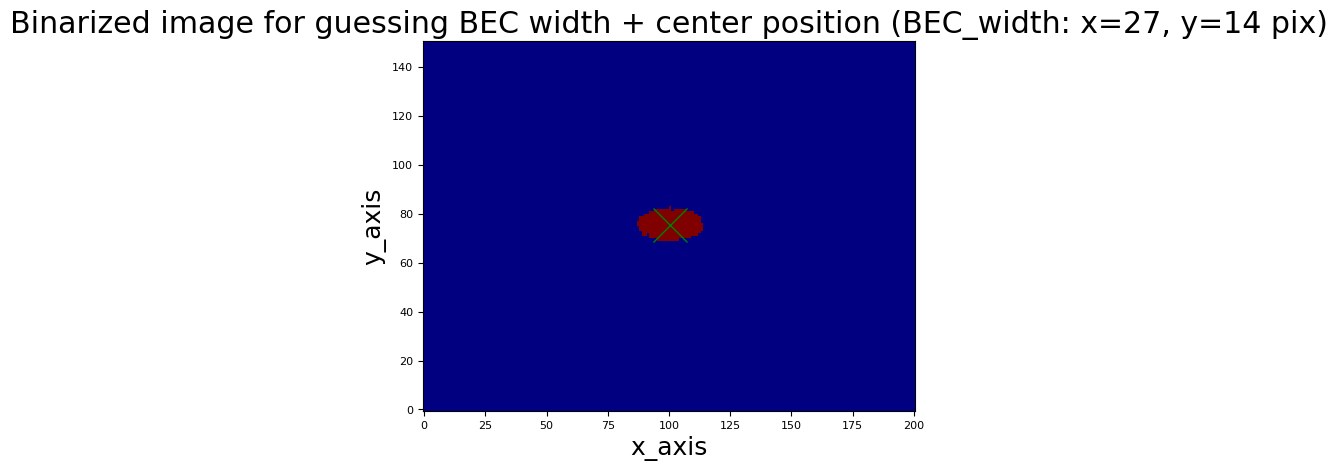

y smaller x, 1d fit along y

1d fit initialization
center = [100.50251256  75.5033557 ]
BEC widths: [27 14]

1d init fit values
Name          Value      Min      Max   Stderr     Vary     Expr Brute_Step
amp_bec       1.802        0    4.685     None     True     None     None
amp_th        1.802        0    4.685     None     True     None     None
deltax           42        0      200     None     True     None     None
sigma_bec     11.48        0       28     None     True     None     None
sigma_th      29.01        0      inf     None    False 0.632*sigma_bec + 0.518*deltax     None
x0_bec         75.5     65.5     85.5     None     True     None     None
x0_th          75.5     65.5     85.5     None     True     None     None
1d fitted values
x0_bec: 75.649, (init = 75.503), bounds = [65.50 : 85.50] 
x0_th: 75.043, (init = 75.503), bounds = [65.50 : 85.50] 
amp_bec: 3.223, (init = 1.802), bounds = [0.00 : 4.68] 
amp_th: 0.355, (init = 1.802), bounds = [0.00 : 4.68] 
sigma_bec: 

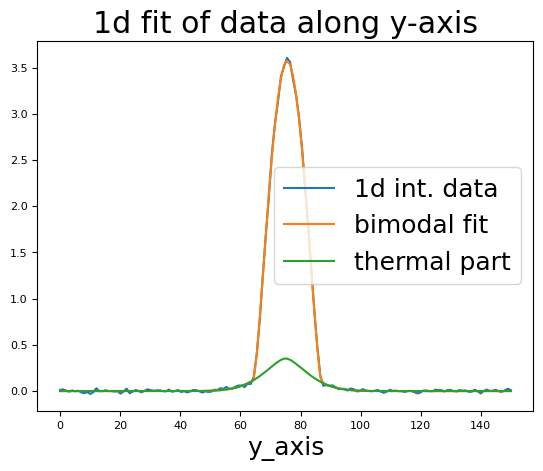


Init Params
Name                    Value      Min      Max   Stderr     Vary     Expr Brute_Step
amp_bec                 3.802        0    6.216     None     True     None     None
amp_th                 0.4182        0    6.216     None     True     None     None
atom_number_bec          1194     -inf      inf     None    False amp_bec / 5 * 2 * 3.14159265359 * sigmax_bec * sigmay_bec     None
atom_number_th          146.6     -inf      inf     None    False amp_th * 2 * 3.14159265359 * 1.20206 / 1.643 * sigma_th * sigma_th     None
condensate_fraction    0.8907     -inf      inf     None    False atom_number_bec / (atom_number_bec + atom_number_th)     None
rot_angle                 -36      -66       -6     None    False     None     None
sigma_th                8.731        0      200     None     True     None     None
sigmax_bec              22.13        0       54     None     True     None     None
sigmay_bec              11.29        0       28     None     True     None    

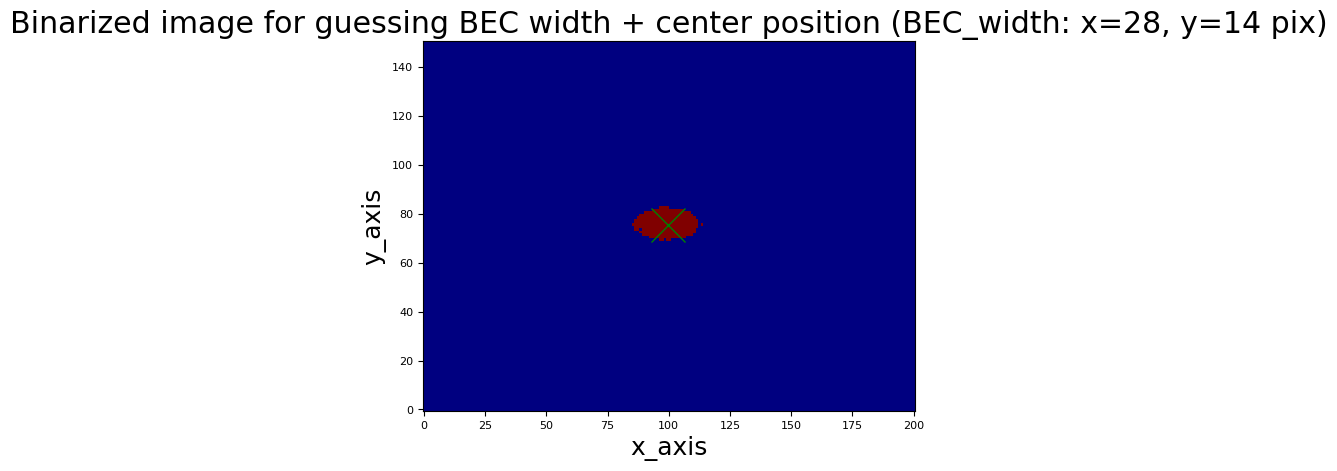

y smaller x, 1d fit along y

1d fit initialization
center = [99.49748744 75.5033557 ]
BEC widths: [28 14]

1d init fit values
Name          Value      Min      Max   Stderr     Vary     Expr Brute_Step
amp_bec       1.774        0    4.612     None     True     None     None
amp_th        1.774        0    4.612     None     True     None     None
deltax           42        0      200     None     True     None     None
sigma_bec     11.48        0       28     None     True     None     None
sigma_th      29.01        0      inf     None    False 0.632*sigma_bec + 0.518*deltax     None
x0_bec         75.5     65.5     85.5     None     True     None     None
x0_th          75.5     65.5     85.5     None     True     None     None
1d fitted values
x0_bec: 75.826, (init = 75.503), bounds = [65.50 : 85.50] 
x0_th: 75.876, (init = 75.503), bounds = [65.50 : 85.50] 
amp_bec: 3.340, (init = 1.774), bounds = [0.00 : 4.61] 
amp_th: 0.193, (init = 1.774), bounds = [0.00 : 4.61] 
sigma_bec: 11

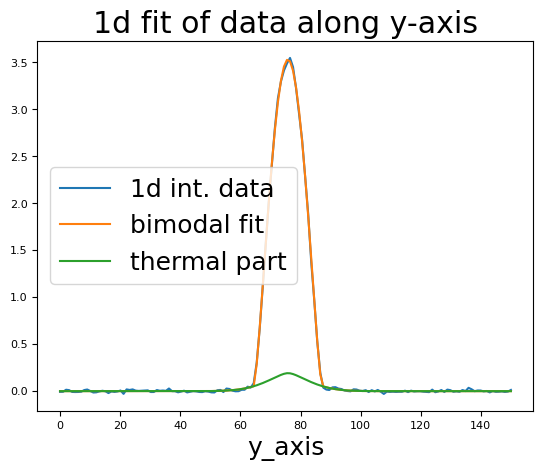


Init Params
Name                    Value      Min      Max   Stderr     Vary     Expr Brute_Step
amp_bec                 4.061        0    6.546     None     True     None     None
amp_th                 0.2343        0    6.546     None     True     None     None
atom_number_bec          1334     -inf      inf     None    False amp_bec / 5 * 2 * 3.14159265359 * sigmax_bec * sigmay_bec     None
atom_number_th          76.31     -inf      inf     None    False amp_th * 2 * 3.14159265359 * 1.20206 / 1.643 * sigma_th * sigma_th     None
condensate_fraction    0.9459     -inf      inf     None    False atom_number_bec / (atom_number_bec + atom_number_th)     None
rot_angle                 -36      -66       -6     None    False     None     None
sigma_th                8.417        0      200     None     True     None     None
sigmax_bec              22.95        0       56     None     True     None     None
sigmay_bec              11.39        0       28     None     True     None    

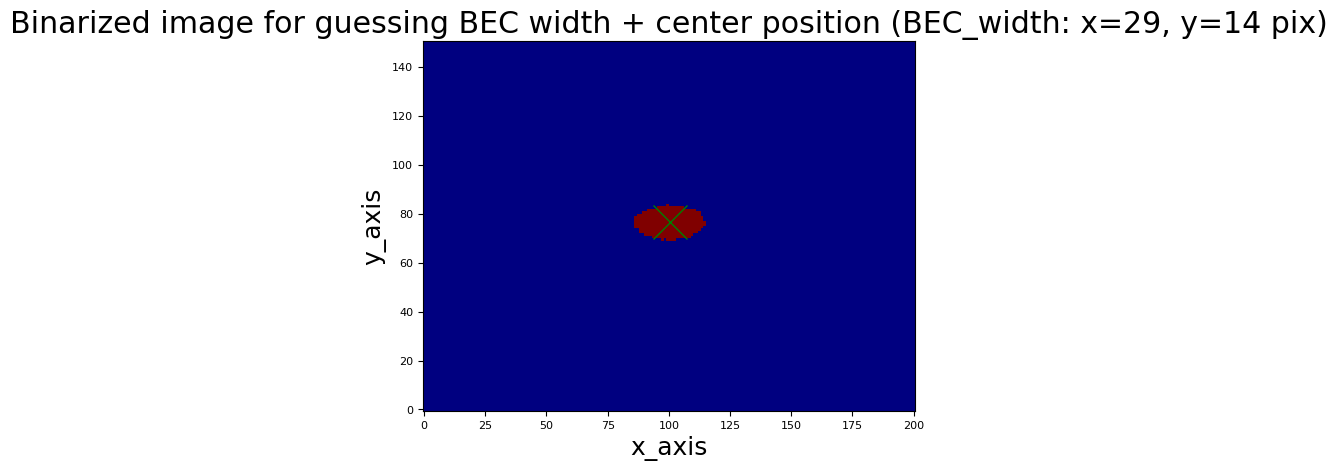

y smaller x, 1d fit along y

1d fit initialization
center = [100.50251256  76.51006711]
BEC widths: [29 14]

1d init fit values
Name          Value      Min      Max   Stderr     Vary     Expr Brute_Step
amp_bec       1.773        0    4.609     None     True     None     None
amp_th        1.773        0    4.609     None     True     None     None
deltax           42        0      200     None     True     None     None
sigma_bec     11.48        0       28     None     True     None     None
sigma_th      29.01        0      inf     None    False 0.632*sigma_bec + 0.518*deltax     None
x0_bec        76.51    66.51    86.51     None     True     None     None
x0_th         76.51    66.51    86.51     None     True     None     None
1d fitted values
x0_bec: 76.407, (init = 76.510), bounds = [66.51 : 86.51] 
x0_th: 75.691, (init = 76.510), bounds = [66.51 : 86.51] 
amp_bec: 3.376, (init = 1.773), bounds = [0.00 : 4.61] 
amp_th: 0.106, (init = 1.773), bounds = [0.00 : 4.61] 
sigma_bec: 

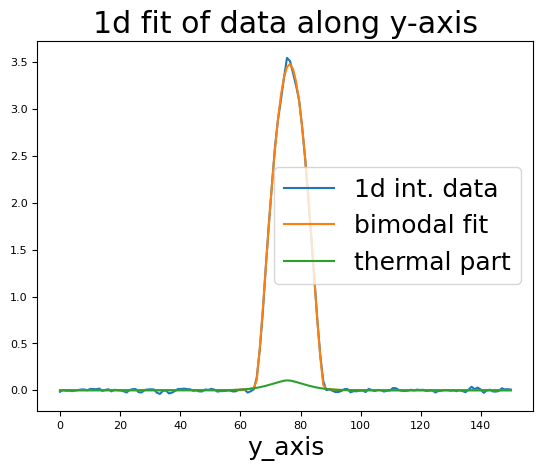


Init Params
Name                    Value      Min      Max   Stderr     Vary     Expr Brute_Step
amp_bec                 4.021        0    5.904     None     True     None     None
amp_th                 0.1265        0    5.904     None     True     None     None
atom_number_bec          1377     -inf      inf     None    False amp_bec / 5 * 2 * 3.14159265359 * sigmax_bec * sigmay_bec     None
atom_number_th          30.54     -inf      inf     None    False amp_th * 2 * 3.14159265359 * 1.20206 / 1.643 * sigma_th * sigma_th     None
condensate_fraction    0.9783     -inf      inf     None    False atom_number_bec / (atom_number_bec + atom_number_th)     None
rot_angle                 -36      -66       -6     None    False     None     None
sigma_th                7.247        0      200     None     True     None     None
sigmax_bec              23.77        0       58     None     True     None     None
sigmay_bec              11.47        0       28     None     True     None    

In [43]:
times = []
x = np.linspace(0,shape[2],shape[2])
y = np.linspace(0,shape[1], shape[1])

X,Y = np.meshgrid(x, y)
X_1d = X.flatten()
Y_1d = Y.flatten()
result = []
for i in range(0, shape[0]):
# for i in [0]:
    print('\n ')
    print(f'file {file} \n image: {i}')
    start = time.time()
    init = fitm.guess(cropOD[i].flatten(), X_1d, Y_1d, rot_angle=36, vary_rot=False)
    init.pretty_print()

    res = fitm.fit(cropOD[i].flatten(), x=X_1d, y=Y_1d, params=init)
    fitm.print_bval(res)
    stop = time.time()
    fitm.return_atom_number(res, X_1d, Y_1d)
    fitm.return_temperature(res, omg=1036.5, tof=26e-3, is_print=False)
    fitm.return_temperature(res, tof=26e-3)

    # print(f'   time = {stop-start:.3f} s')

    result.append(res)
    times.append(stop-start)

times = np.array(times)

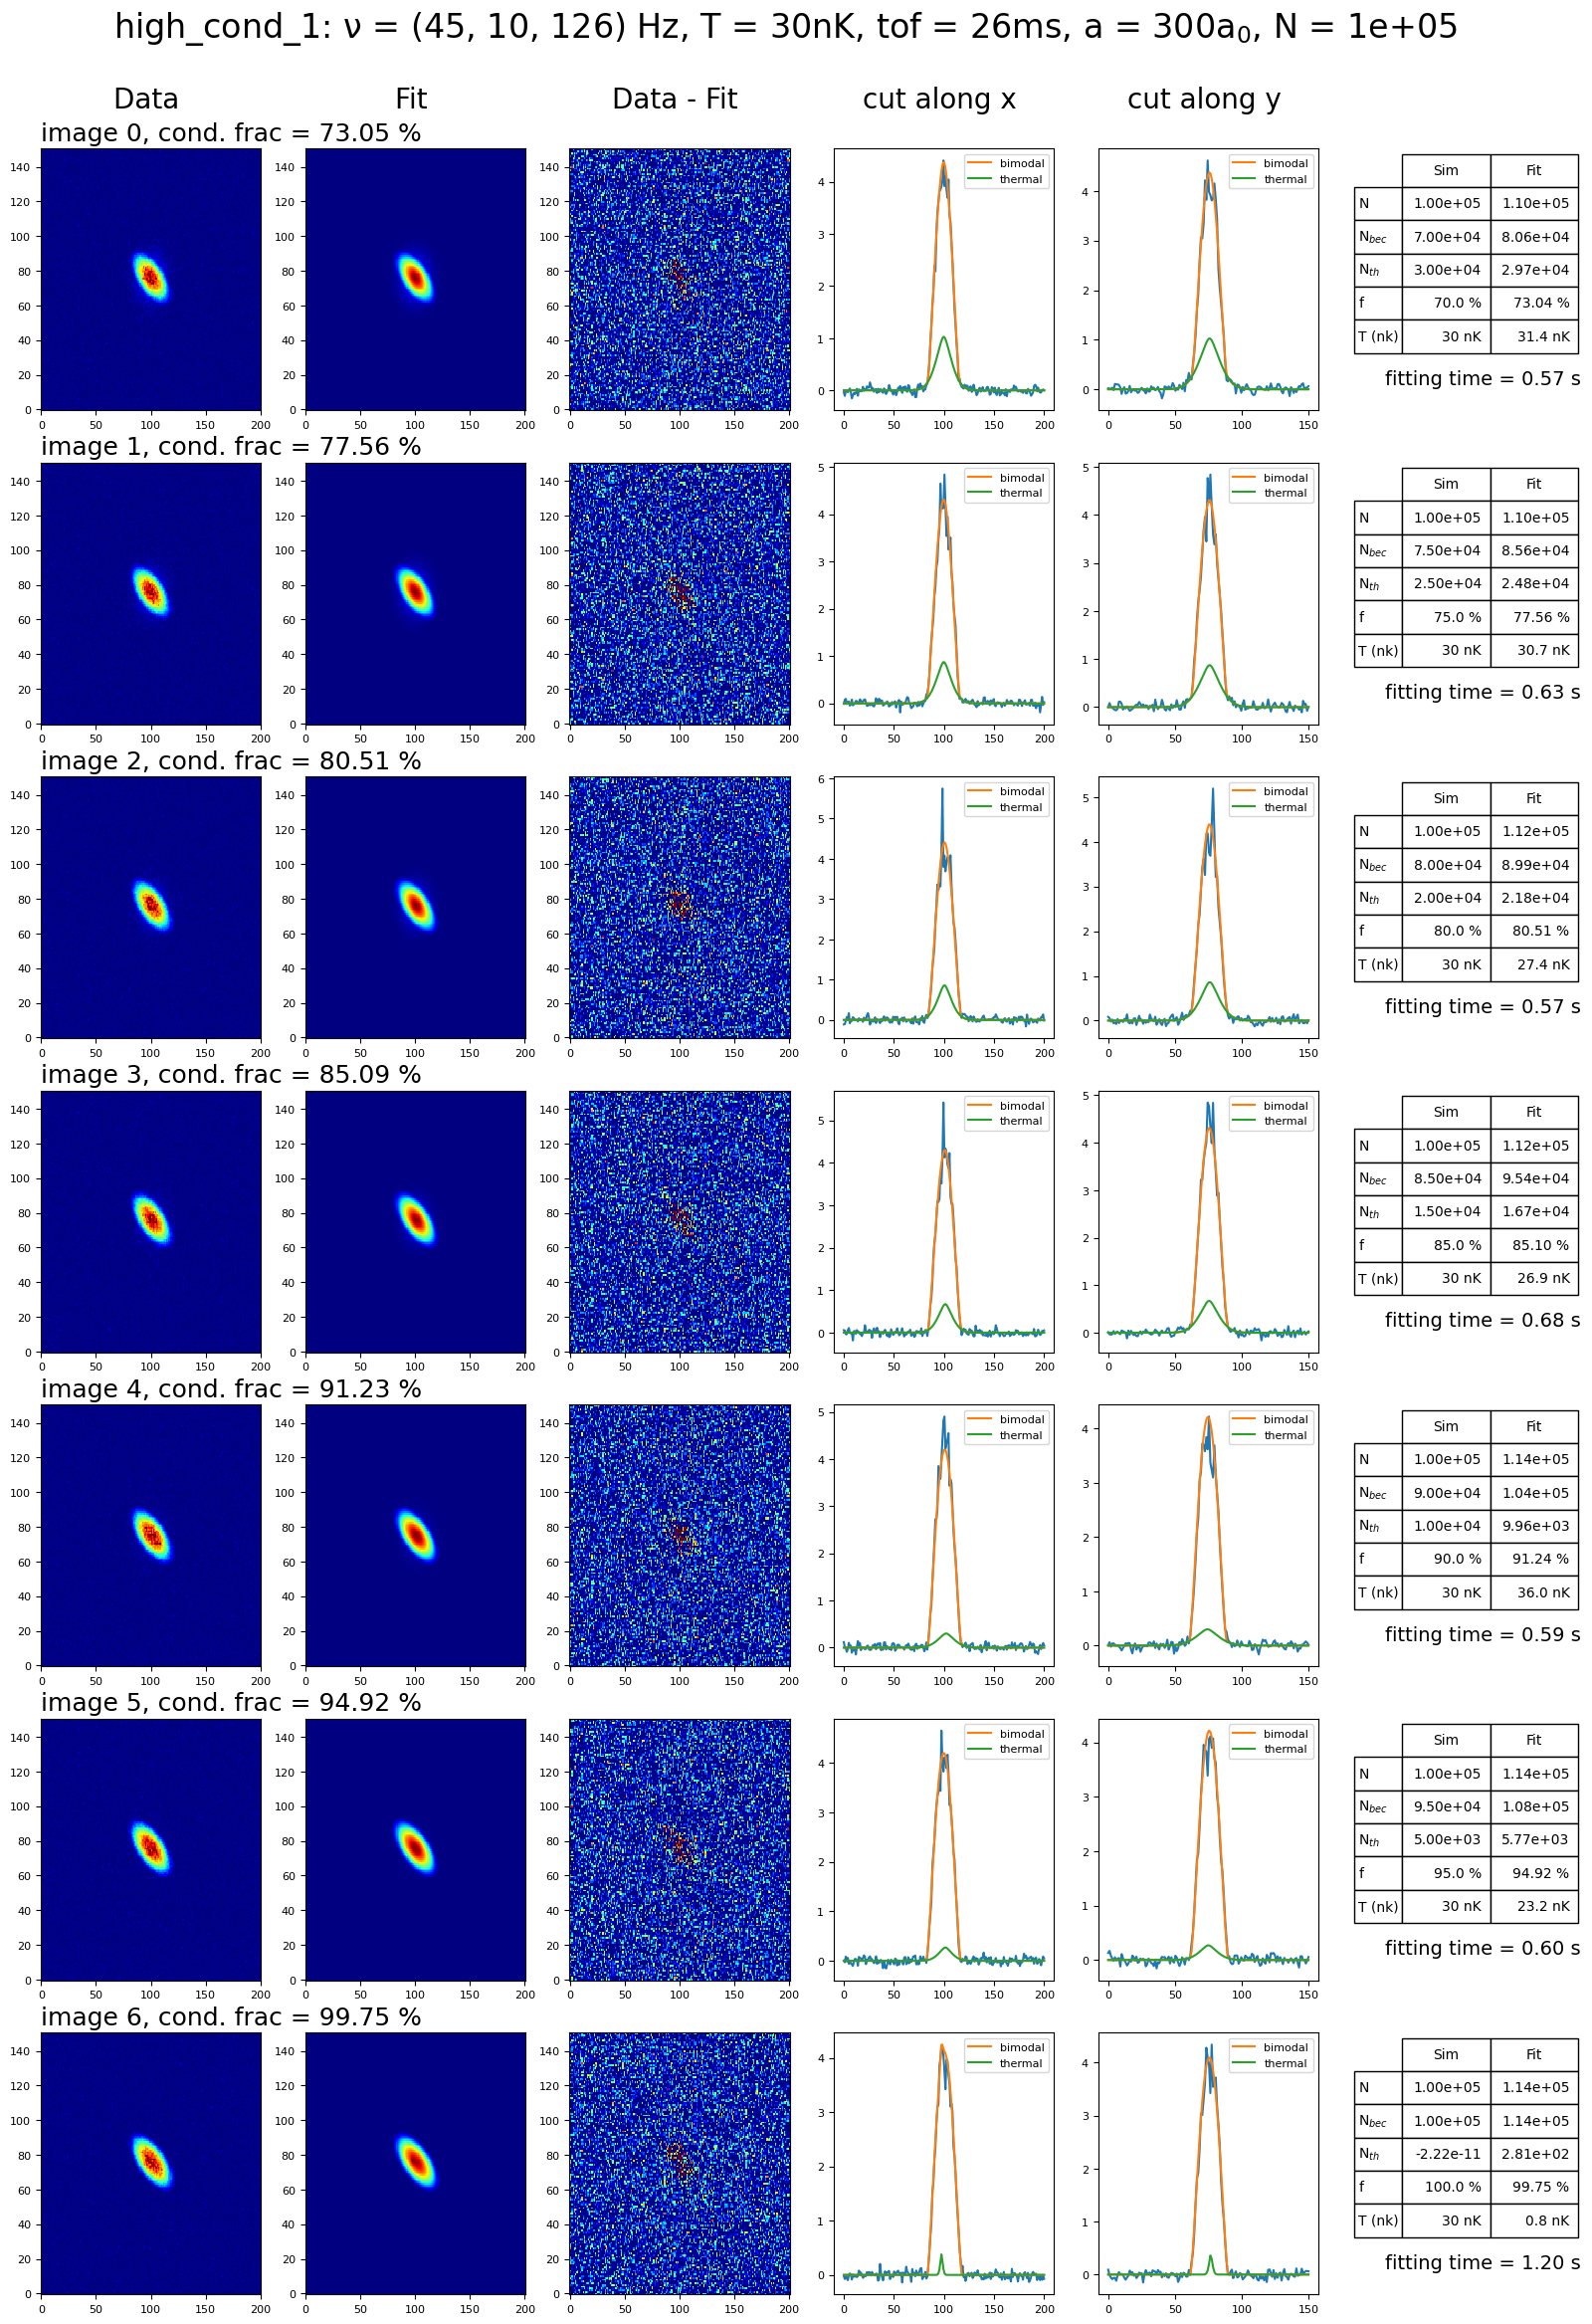

In [44]:
# fig, axs = plt.subplots(shape[0] , 5, figsize=(14, 4 * shape[0] ),dpi = 100)

fig, axs = plt.subplots(shape[0] , 6, figsize=(20,4 * shape[0] ),dpi = 100)
fig.suptitle(f'{file}: ν = ({data_x.trap_f[0]}, {data_x.trap_f[1]}, {data_x.trap_f[2]}) Hz, T = {data_x.temp[0]*1e9:.0f}nK, tof = {data_x.tof * 1e3:.0f}ms, a = {data_x.a_fac :.0f}a$_0$, N = {data_x.N:.0e} ', y=-0.005*shape[0]+0.965, fontsize=24)
# fig.suptitle('test', va='bottom')

for i in range(0,shape[0]):

    axs[i,0].set_title(f'image {i}, cond. frac = {fitm.cond_frac(result[i], X, Y) *1e2:.2f} %', loc='left', fontsize=18)

    lmfit.fit_report(result[i])
    bval = result[i].best_values
    fit = dp.density_profile_BEC_2d(X,Y, **bval)
    vmax = np.max(fit)

    if bval['amp_bec'] > bval['amp_th']:
        cen_str = 'bec'
    else:
        cen_str = 'th'
    cen_x = round(bval[f'x0_{cen_str}'])
    cen_y = round(bval[f'y0_{cen_str}'])

    ax = axs[i,0]
    ax.pcolormesh(X, Y, cropOD[i], vmin=0, vmax=vmax, cmap='jet', shading='auto')
    #plt.colorbar(art, ax=ax, label='z')


    # Plot gaussian 2d Fit + legend including Width parameters
    ax = axs[i,1]

    ax.pcolormesh(X, Y, fit, vmin=0, vmax=vmax, cmap='jet', shading='auto')
    #plt.colorbar(art, ax=ax, label='z')

    ax = axs[i,2]

    ax.pcolormesh(X, Y, fit-cropOD[i], vmin=0, vmax=0.2, cmap='jet', shading='auto')


    ax = axs[i,3]

    ax.plot(x, cropOD[i, cen_y, :])
    ax.plot(x, fit[cen_y, :], label='bimodal')
    ax.plot(x, dp.thermal(x, bval['x0_th'], bval['amp_th'], bval['sigma_th']), label='thermal')
    ax.legend(fontsize=8)

    ax = axs[i,4]

    ax.plot(y, cropOD[i, :, cen_x])
    ax.plot(y, fit[:, cen_x], label='bimodal')
    ax.plot(y, dp.thermal(y, bval['y0_th'], bval['amp_th'], bval['sigma_th']), label='thermal')
    ax.legend(fontsize=8)

    ax = axs[i,5]
    Na = fitm.return_atom_number(result[i], X, Y, is_print=False)
    ax.axis('off')
    col_labels = ['Sim', 'Fit']
    row_labels = ['N', f'N$_{{bec}}$', f'N$_{{th}}$','f', 'T (nk)']
    table_vals = [[f'{data_x.N:.2e}',f"{Na['N']:.2e}"],
                  [f'{data_x.cond_frac.data[i] * data_x.N:.2e}',f"{Na['N_bec']:.2e}"],
                  [f'{(1-data_x.cond_frac.data[i]) * data_x.N:.2e}',f"{Na['N_th']:.2e}"],
                  [f'{data_x.cond_frac.data[i] *1e2:.1f} %', f"{Na['cond_f'] *1e2:.2f} %"],
                  [f'{data_x.temp[i] *1e9:.0f} nK', f'{fitm.return_temperature(result[i], tof=data_x.tof, is_print=False)*1e9:.1f} nK']
                  ]


    my_table = ax.table(cellText=table_vals,
                        colWidths=[0.4]*2,
                        rowLabels=row_labels,
                        colLabels=col_labels,
                        loc='upper right')
    my_table.scale(1,2)
    ax.text(0.1,0.1,f'fitting time = {times[i]:.2f} s', fontsize=14)

t_fonts=20
axs[0,0].set_title(f'Data \n ', fontsize=t_fonts)
axs[0,1].set_title('Fit \n ', fontsize=t_fonts)
axs[0,2].set_title('Data - Fit \n ', fontsize=t_fonts)
axs[0,3].set_title('cut along x \n ', fontsize=t_fonts)
axs[0,4].set_title('cut along y \n ', fontsize=t_fonts)


# plt.tight_layout()
# plt.savefig(f'fit_output/final/{file}_{saveprefix}.png')
plt.show()

In [32]:
data_x.temp

array([3.e-08, 3.e-08, 3.e-08, 3.e-08, 3.e-08, 3.e-08, 3.e-08])